In [2]:
import os
import gc
import json
from functools import partial
import multiprocessing as mp
from timeit import default_timer as timer

import numpy as np
from scipy import stats
import numpy as np

import cv2
from skimage import morphology

from cityscapes import *
from IPython.display import display, clear_output

In [2]:
test_run = False
generate_results = False
memmap_data = True
visualize = True
res = 20

dataset_path = '/home/c276huan/bayesian-segmentation/models/deeplab/datasets/cityscapes'
val_path = dataset_path + '/leftImg8bit/val'
vis_path = '/media/c276huan/2e796c80-9da9-4968-99d7-661ea3b8f111/raw_segmentation_results3k'
out_path = '/home/c276huan/bayesian-segmentation/persons_depth_occlusion/out3k'
mmap_path = 'data3k.npy'

In [4]:
# Convert given disparity map to a depth map based on
# certain camera parameters
def disp2depth(disp, cam):
    # convert disparity to depth
    mask = disp != 0
    disp = mask * ((disp.astype(np.float32)-1.) / 255.)
    with np.errstate(divide='ignore'):
        depth = (cam['extrinsic']['baseline'] * cam['intrinsic']['fx']) / disp
    depth[disp == 0] = 0
    return depth

# Helper function to convert raw prediction result
# to a label by selecting the category with the 
# largest output
def pr_row(r):
    return [trainId2label[np.argmax(px)].id for px in r]

# Helper function to visualize the segmentation result
# by assigning each label its corresponding color
def vis_row(r):
    return [id2label[px].color for px in r]

# Process a person object in the image
def process_person(obj, annot, depth, pred, al, mi):
    if name2labelCp[obj['label']].ignoreInEval:
        return np.array([])
    # Get bounding boxes for the entire person and visible area
    x, y, w, h = obj['bbox']
    x_vis, y_vis, w_vis, h_vis = obj['bboxVis']

    # Compute occlusion level
    occlusion = (1 - (w_vis*h_vis) / (w*h)) * 100

    # Iterate all pixels that have label 'human'
    pts = []
    for u in range(y_vis, min(1024, y_vis+h_vis)):
        for v in range(x_vis, min(2048, x_vis+w_vis)):
            if depth[u,v] != 0:
                true_label = id2label[annot[u,v]]
                pred_label = id2label[pred[u,v]]
                if (true_label.categoryId == 6):
                    pts.append([true_label.id, pred_label.id,
                                depth[u,v], occlusion,
                                al[u,v], mi[u,v]])
    return pts

In [5]:
def process_image(name, dataset_path, vis_path, payload_keys=[], out_path=None, out_file=None, pool=None):
    city = name.split('_')[0]
    
    load_img = 'img' in payload_keys
    load_annot_vis = 'annot_vis' in payload_keys
    load_pred_vis = 'pred_vis' in payload_keys
    
    local_pool = pool == None
    if local_pool:
        pool = mp.pool.ThreadPool()
    
    img_path   = dataset_path + '/leftImg8bit/val/' + city + '/' + name + '_leftImg8bit.png'
    annot_path = img_path.replace('leftImg8bit.png', 'gtFine_labelIds.png')\
                         .replace('leftImg8bit', 'gtFine')
    # annot_vis_path = annot_path.replace('labelIds', 'color')
    disp_path  = img_path.replace('leftImg8bit', 'disparity')
    cam_path   = img_path.replace('leftImg8bit', 'camera') \
                         .replace('.png', '.json')
    bbox_path  = img_path.replace('leftImg8bit', 'gtBboxCityPersons')\
                         .replace('.png', '.json')
    pred_path    = vis_path + '/PR_b\'' + name + '\'.npy'
    al_path    = vis_path + '/AL_b\'' + name + '\'.npy'
    mi_path    = vis_path + '/MI_b\'' + name + '\'.npy'

    # Original image
    if load_img:
        img = cv2.imread(img_path)

    # Annotation and its visualization
    annot = np.array(cv2.imread(annot_path, cv2.IMREAD_UNCHANGED))
    # annot_vis   = cv2.imread(seg_path) / 255
    if load_annot_vis:
        annot_vis = pool.map(vis_row, annot)
    
    # Bounding box for human objects
    with open(bbox_path, 'r') as bbox_file:
        bbox = json.load(bbox_file)
    
    # Disparity map
    disp = np.array(cv2.imread(disp_path,  cv2.IMREAD_UNCHANGED))

    # Camera calibration parameter estimates
    with open(cam_path, 'r') as cam_file:
        cam = json.load(cam_file)

    # Depth map
    depth = disp2depth(disp, cam)

    # Prediction and its visualization
    pred = np.array(pool.map(pr_row, np.load(pred_path)))
    if load_pred_vis:
        pred_vis = pool.map(vis_row, pred)
    
    # Aleatoric uncertainty estimates
    al = np.array(np.load(al_path))
    
    # Mutual information (epistemic uncertainty) estimates
    mi = np.array(np.load(mi_path))

    # Process each person object present in the image
    result = []
    process_person_star = partial(process_person,
                                  annot=annot, depth=depth,
                                  pred=pred, al=al, mi=mi)
    
    for pxs in pool.map(process_person_star, bbox['objects'], chunksize=1):
        result.extend(pxs)

    if local_pool:
        pool.close()
        pool.join()
    
    if out_path:
        np.save(out_path + '/' + name + '_persons_depth_occlusion.npy', result)
    elif out_file:
        np.save(out_file, result)
        
    result = np.array(result)
    
    if len(payload_keys) > 0:
        payload = {
            'img': img,
            'annot': annot,
            'bbox': bbox,
            'disp': disp,
            'depth': depth,
            'pred': pred,
            'al': al,
            'mi': mi,
        }
        if load_img:
            payload['img'] = img
        if load_annot_vis:
            payload['annot_vis'] = annot_vis
        if load_pred_vis:
            payload['pred_vis'] = pred_vis
        payload = {k: payload[k] for k in payload_keys}
        return result, payload
    else:
        return result

In [6]:
# Helpers for displaying CityScapes colormap

from matplotlib.colors import ListedColormap
cityscapes_cmap = ListedColormap([np.array(label.color)/255 for label in labels if not label.ignoreInEval])
def show_cityscapes_colorbar(ax):
    catc = len(cityscapes_cmap.colors)
    y_axis = plt.colorbar(ax).ax.get_yaxis()
    y_axis.set_ticks((np.array(range(catc))+.5)/catc * 255)
    y_axis.set_ticklabels([label.name for label in labels if not label.ignoreInEval])

In [7]:
if test_run:
    start=timer()
    result, payload = process_image('frankfurt_000001_002512', dataset_path, vis_path,
                                    payload_keys=['img', 'annot_vis', 'pred_vis', 'al', 'mi'],
                                    out_file='/home/c276huan/Desktop/test.npy')
    print(timer()-start)
    print(result)

In [8]:
if test_run:
    plt.figure(figsize=(20,40))

    plt.subplot(511)
    plt.title('Original Image')
    plt.imshow(payload['img'])

    plt.subplot(512)
    plt.title('Ground Truth')
    ax = plt.imshow(payload['annot_vis'], cmap=cityscapes_cmap)
    show_cityscapes_colorbar(ax)

    plt.subplot(513)
    plt.title('Prediction')
    ax = plt.imshow(payload['pred_vis'], cmap=cityscapes_cmap)
    show_cityscapes_colorbar(ax)

    plt.subplot(514)
    plt.title('Aleatoric Uncertainty')
    ax = plt.imshow(payload['al'])
    plt.colorbar(ax)

    plt.subplot(515)
    plt.title('Mutual Information (Epistemic Uncertainty)')
    ax = plt.imshow(payload['mi'])
    plt.colorbar(ax)

    plt.show()

In [9]:
if generate_results:
    time = 0
    pool = mp.Pool()
    process_image_partial = partial(process_image, dataset_path=dataset_path, vis_path=vis_path, out_path=out_path)
    
    start = timer()
    avg_time = 0
    completed = 0
    
    def process_image_cb(name):
        def f(x):
            global completed
            global avg_time
            completed = completed + 1
            avg_time = (timer() - start) / completed
            clear_output(wait=True)
            display(str(completed) + '/500  -  Completed ' + name + 
                    ', avg time ' + str(avg_time) +
                    ', remaining ' + str((500-completed)*avg_time))
        return f

    for cityname in os.listdir(val_path):
        for filename in os.listdir(val_path + '/' + cityname):
            name = filename.replace('_leftImg8bit.png', '')
            pool.apply_async(process_image, args=(name, dataset_path, vis_path, [], out_path), callback=process_image_cb(name))

    pool.close()
    pool.join()

In [10]:
if memmap_data or visualize:
    data_size = 0
    for i, data_file in enumerate(os.listdir(out_path)):
        data_size = data_size + len(np.load(out_path  + '/' + data_file, allow_pickle=True))
        if (i+1) % 10 == 0:
            clear_output(wait=True)
            display(str(i+1) + '/500')
    print(data_size)

'500/500'

15044456


In [11]:
if memmap_data:
    data = np.memmap(mmap_path, dtype=float, mode='w+', shape=(data_size, 6))
    offset = 0
    for i, data_file in enumerate(os.listdir(out_path)):
        tmp = np.load(out_path  + '/' + data_file)
        if len(tmp) != 0:
            data[offset:offset + len(tmp)] = tmp
            offset = offset + len(tmp)
        if (i+1) % 10 == 0:
            clear_output(wait=True)
            display(str(i+1) + '/500')
    del data

'500/500'

In [12]:
if visualize:
    data = np.memmap(mmap_path, dtype=float, shape=(data_size, 6))
    data = data[np.abs(stats.zscore(data[:,2])) < 1.96]
    

    depth_axis = np.linspace(0, data[:,2].max(), res+1)
    occlusion_axis = np.linspace(0, 100, res+1)
    depth_step = data[:,2].max()/res
    occlusion_step = 100/res
    
    zzz = np.zeros((res+1,res+1,3))
    
    start = timer()
    avg_time = 0
    completed = 0
    
    def process_zvalue(d, o):
        data_in = data[(data[:,2] >= d) &
                       (data[:,2] < d+depth_step) &
                       (data[:,3] >= o) &
                       (data[:,3] < o+occlusion_step)]
        z = np.zeros(3)
        if len(data_in) > 0:
            data_in_correct = data_in[data_in[:,0] == data_in[:,1]]
            z[0] = float(len(data_in_correct)) / len(data_in)
            z[1:3] = data_in[:,4:6].mean(axis=0)
        return z

    def update_zvalue_cb(di, oi):
        def f(z):
            global completed
            global avg_time
            completed = completed + 1
            avg_time = (timer() - start) / completed
            
            zzz[di,oi] = z
            clear_output(wait=True)
            display(str(completed) + '/' + str(res*res) +
                    '  -  Completed ' + str(di+1) + '-' + str(oi+1) +
                    ', avg time ' + str(avg_time) +
                    ', remaining ' + str((res*res-completed)*avg_time))
        return f

    pool = mp.Pool()

    for di in range(res):
        for oi in range(res):
            pool.apply_async(process_zvalue, args=(depth_axis[di],occlusion_axis[oi]), callback=update_zvalue_cb(di,oi))

    pool.close()
    pool.join()

'400/400  -  Completed 20-20, avg time 0.09184460557240527, remaining 0.0'

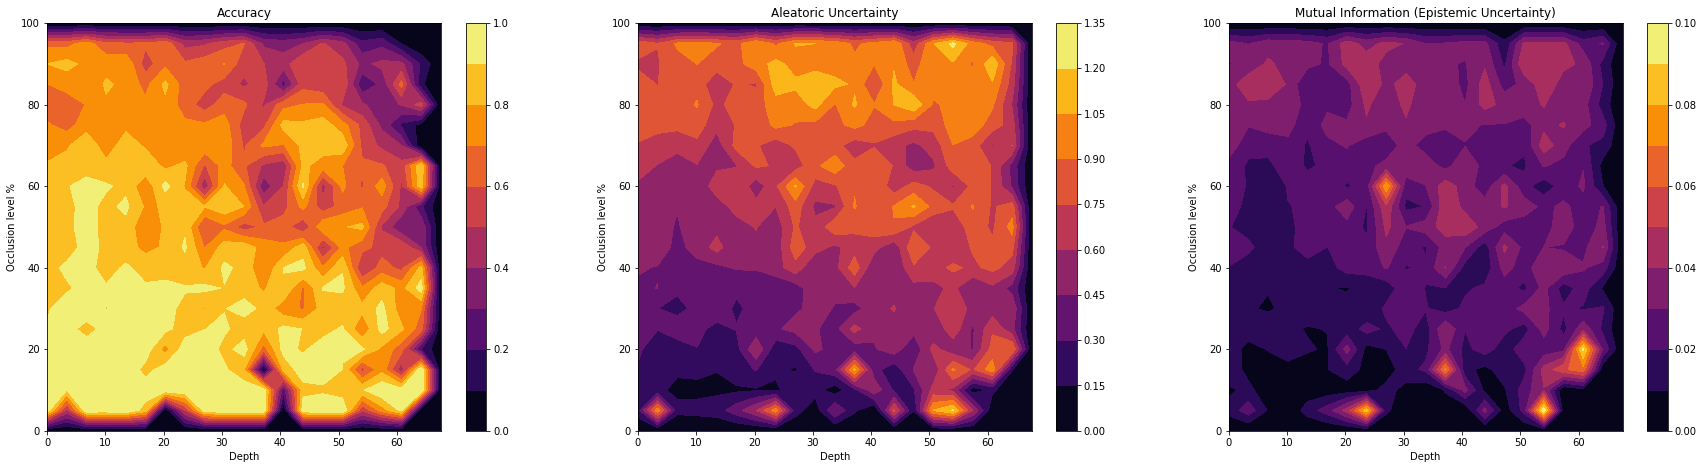

In [13]:
if visualize:
    plt.figure(figsize=(30,7.5), facecolor='white')

    for i, title in enumerate(['Accuracy', 'Aleatoric Uncertainty', 'Mutual Information (Epistemic Uncertainty)']):
        ax = plt.subplot(1,3,1+i)
        plt.title(title)
        plt.xlabel('Depth')
        plt.ylabel('Occlusion level %')
#         ax.contour(depth_axis, occlusion_axis, zzz[:,:,i], levels=3, cmap="Purples")
        contour = ax.contourf(depth_axis, occlusion_axis, zzz[:,:,i], levels=10, cmap='inferno')
        plt.colorbar(contour)

    plt.show()

Depth-accuracy p-value: 6.546087758458e-09    20/20 significant
Depth-AL p-value: 5.064570259452664e-09    20/20 significant
Depth-MI p-value: 3.3393367255721546e-09    20/20 significant


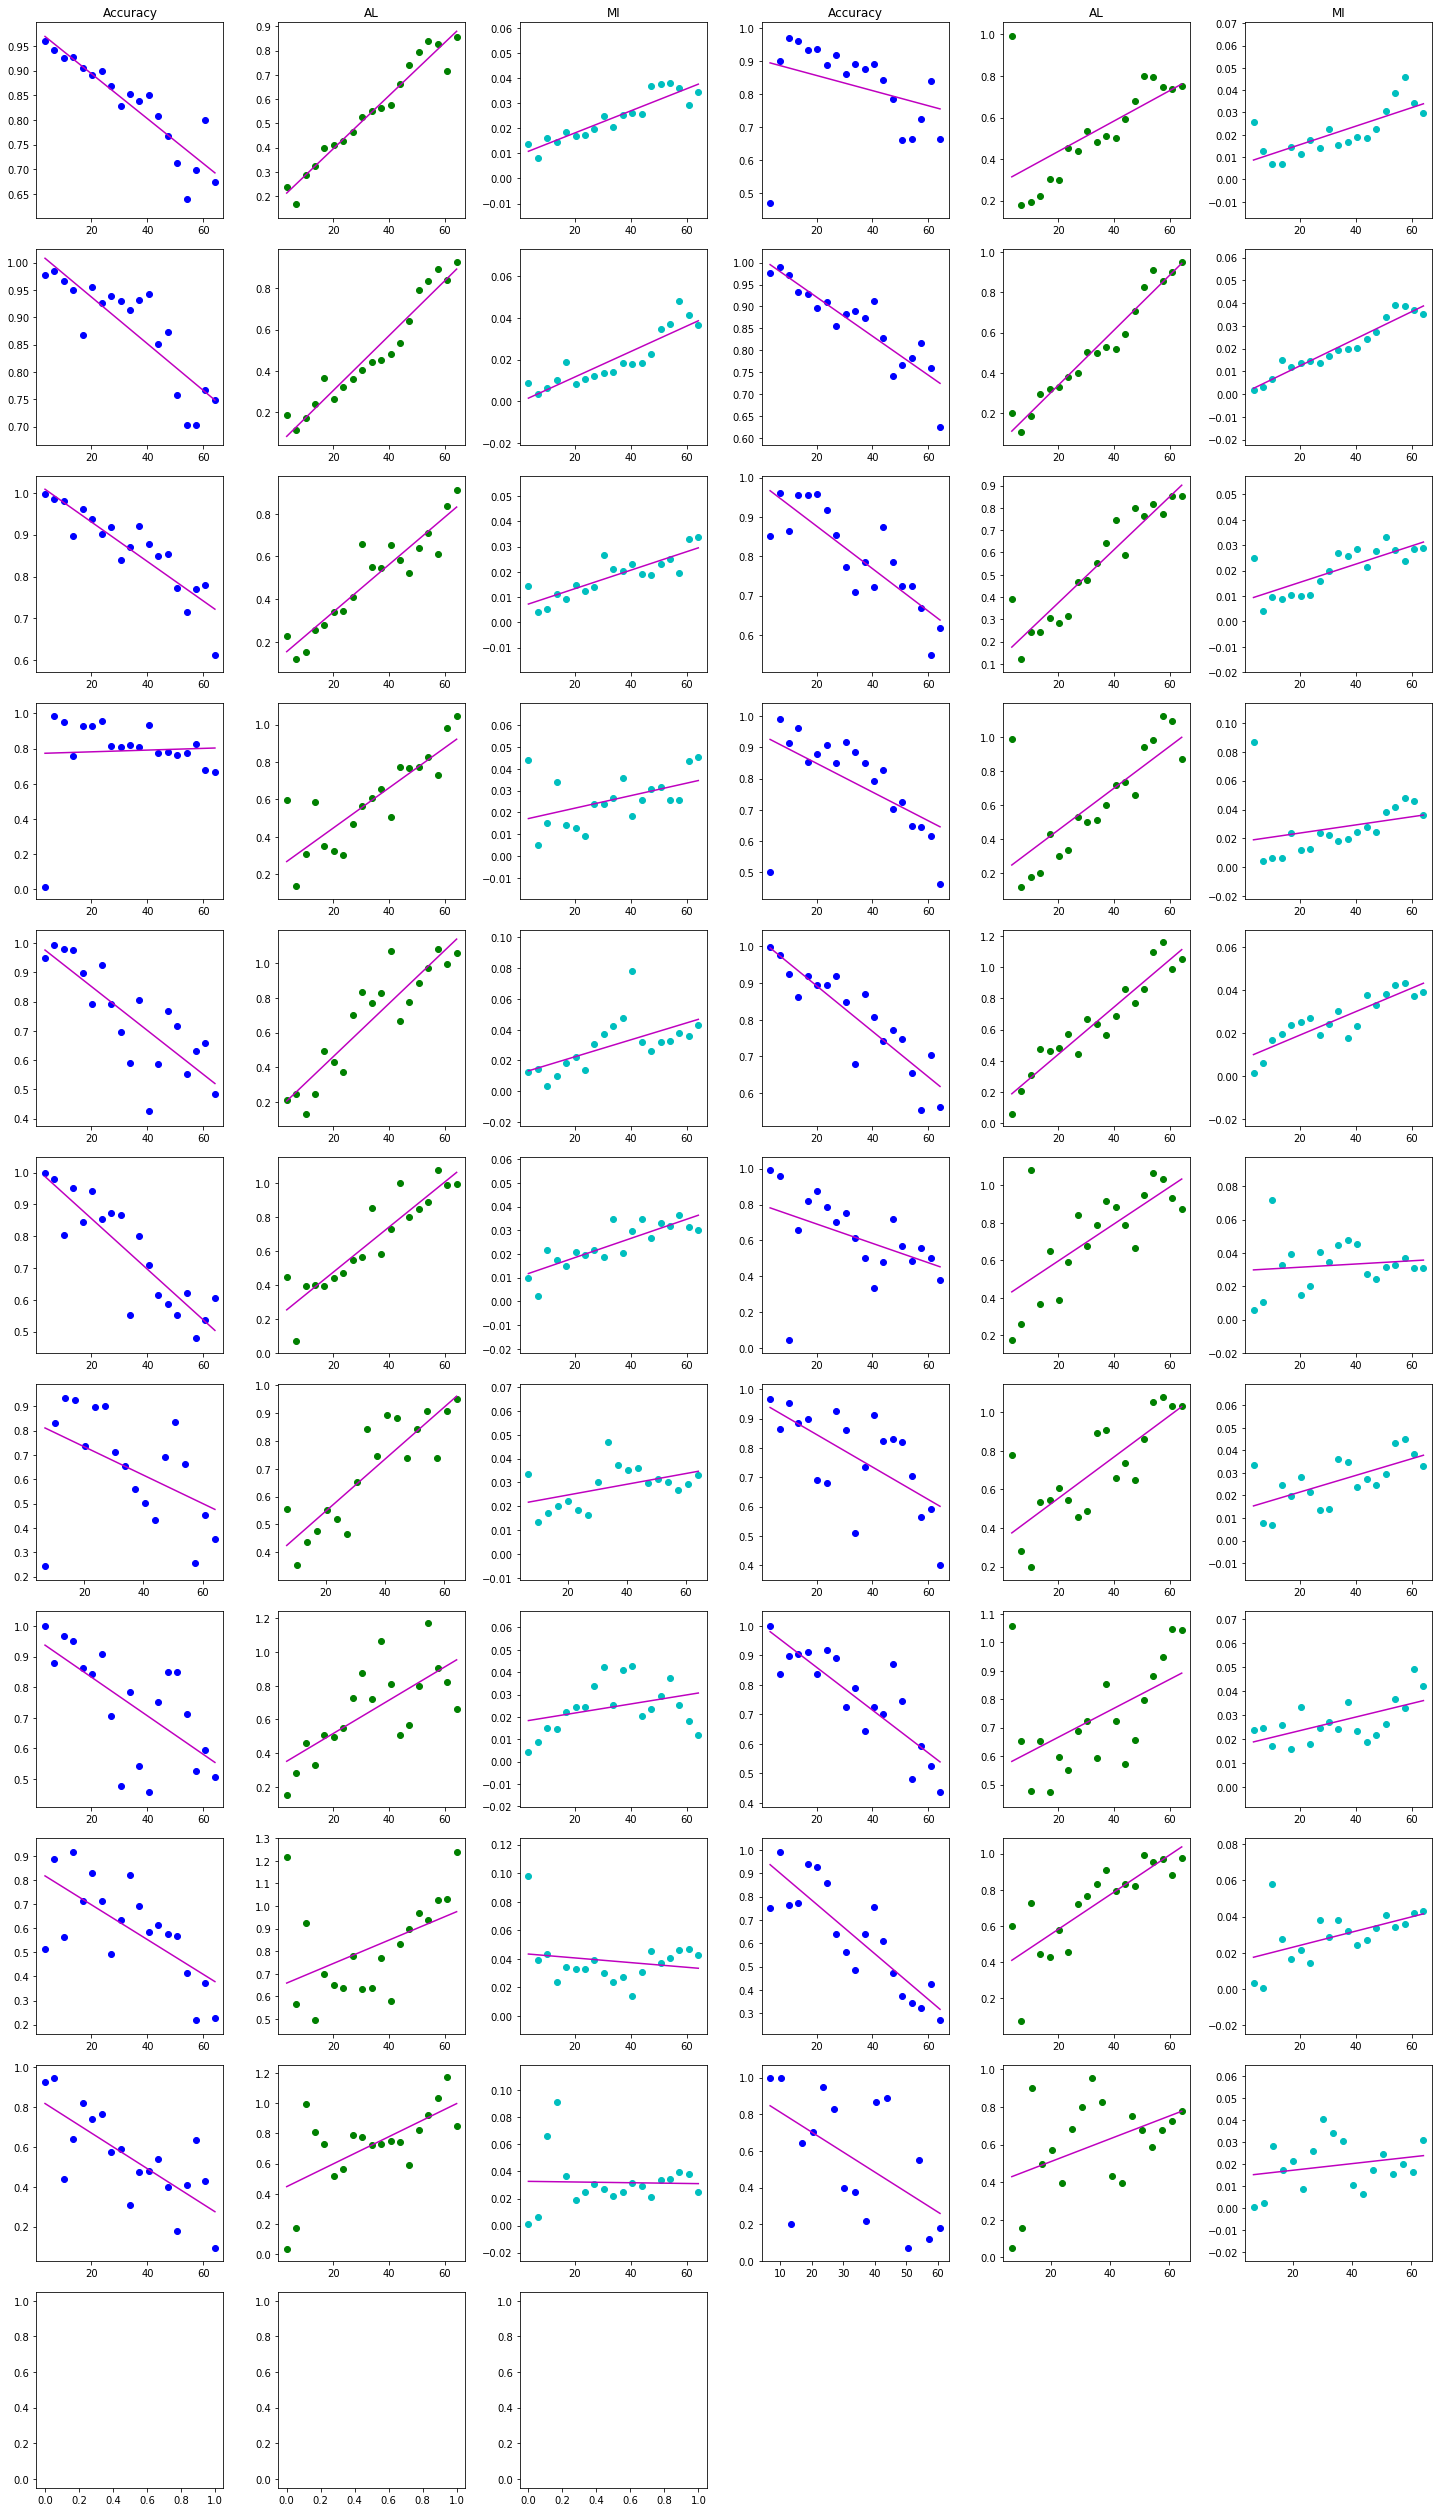

In [14]:
if visualize:
    ylabels = ['Accuracy', 'AL', 'MI']
    colors = ['b', 'g', 'c']
    col = 2
    pvalues = np.empty((3,res+1))
    
    plt.figure(figsize=( 20,20/(col*len(ylabels))*((res+1)/2) ),
               facecolor='white')

    for i in range(res+1):
        for j, ylabel in enumerate(ylabels):
            plt.subplot(int(np.ceil((res+1)/col)), col*len(ylabels), i*len(ylabels)+j+1)
            if i < 2:
                plt.title(ylabel)
            corr_axis = zzz[:,i,j]
            corr_mask = corr_axis != 0
            corr_plot_x = depth_axis[corr_mask]
            corr_plot_y = corr_axis[corr_mask]

            plt.scatter(corr_plot_x, corr_plot_y, color=colors[j])
            if corr_plot_x.size > 1:
                f = np.poly1d(np.polyfit(corr_plot_x, corr_plot_y, 1))
                plt.plot(corr_plot_x, f(corr_plot_x), color='m')

            _, pvalues[j,i] = stats.ttest_ind(corr_plot_x, corr_plot_y)

    pvalues_accuracy = pvalues[0][~np.isnan(pvalues[0])]
    pvalues_al = pvalues[1][~np.isnan(pvalues[1])]
    pvalues_mi = pvalues[2][~np.isnan(pvalues[2])]
    print('Depth-accuracy p-value: ' + str(pvalues_accuracy.mean()) + '    ' + 
           str(pvalues_accuracy[pvalues_accuracy < .05].size) + '/' + str(pvalues_accuracy.size) + ' significant')
    print('Depth-AL p-value: ' + str(pvalues_al.mean()) + '    ' + 
           str(pvalues_al[pvalues_al < .05].size) + '/' + str(pvalues_al.size) + ' significant')
    print('Depth-MI p-value: ' + str(pvalues_mi.mean()) + '    ' + 
           str(pvalues_mi[pvalues_mi < .05].size) + '/' + str(pvalues_mi.size) + ' significant')

    plt.tight_layout()
    plt.show()

Occlusion-accuracy p-value: 3.5426413028415485e-08    19/19 significant
Occlusion-AL p-value: 2.9697310867389724e-08    19/19 significant
Occlusion-MI p-value: 2.2979636166245305e-08    19/19 significant


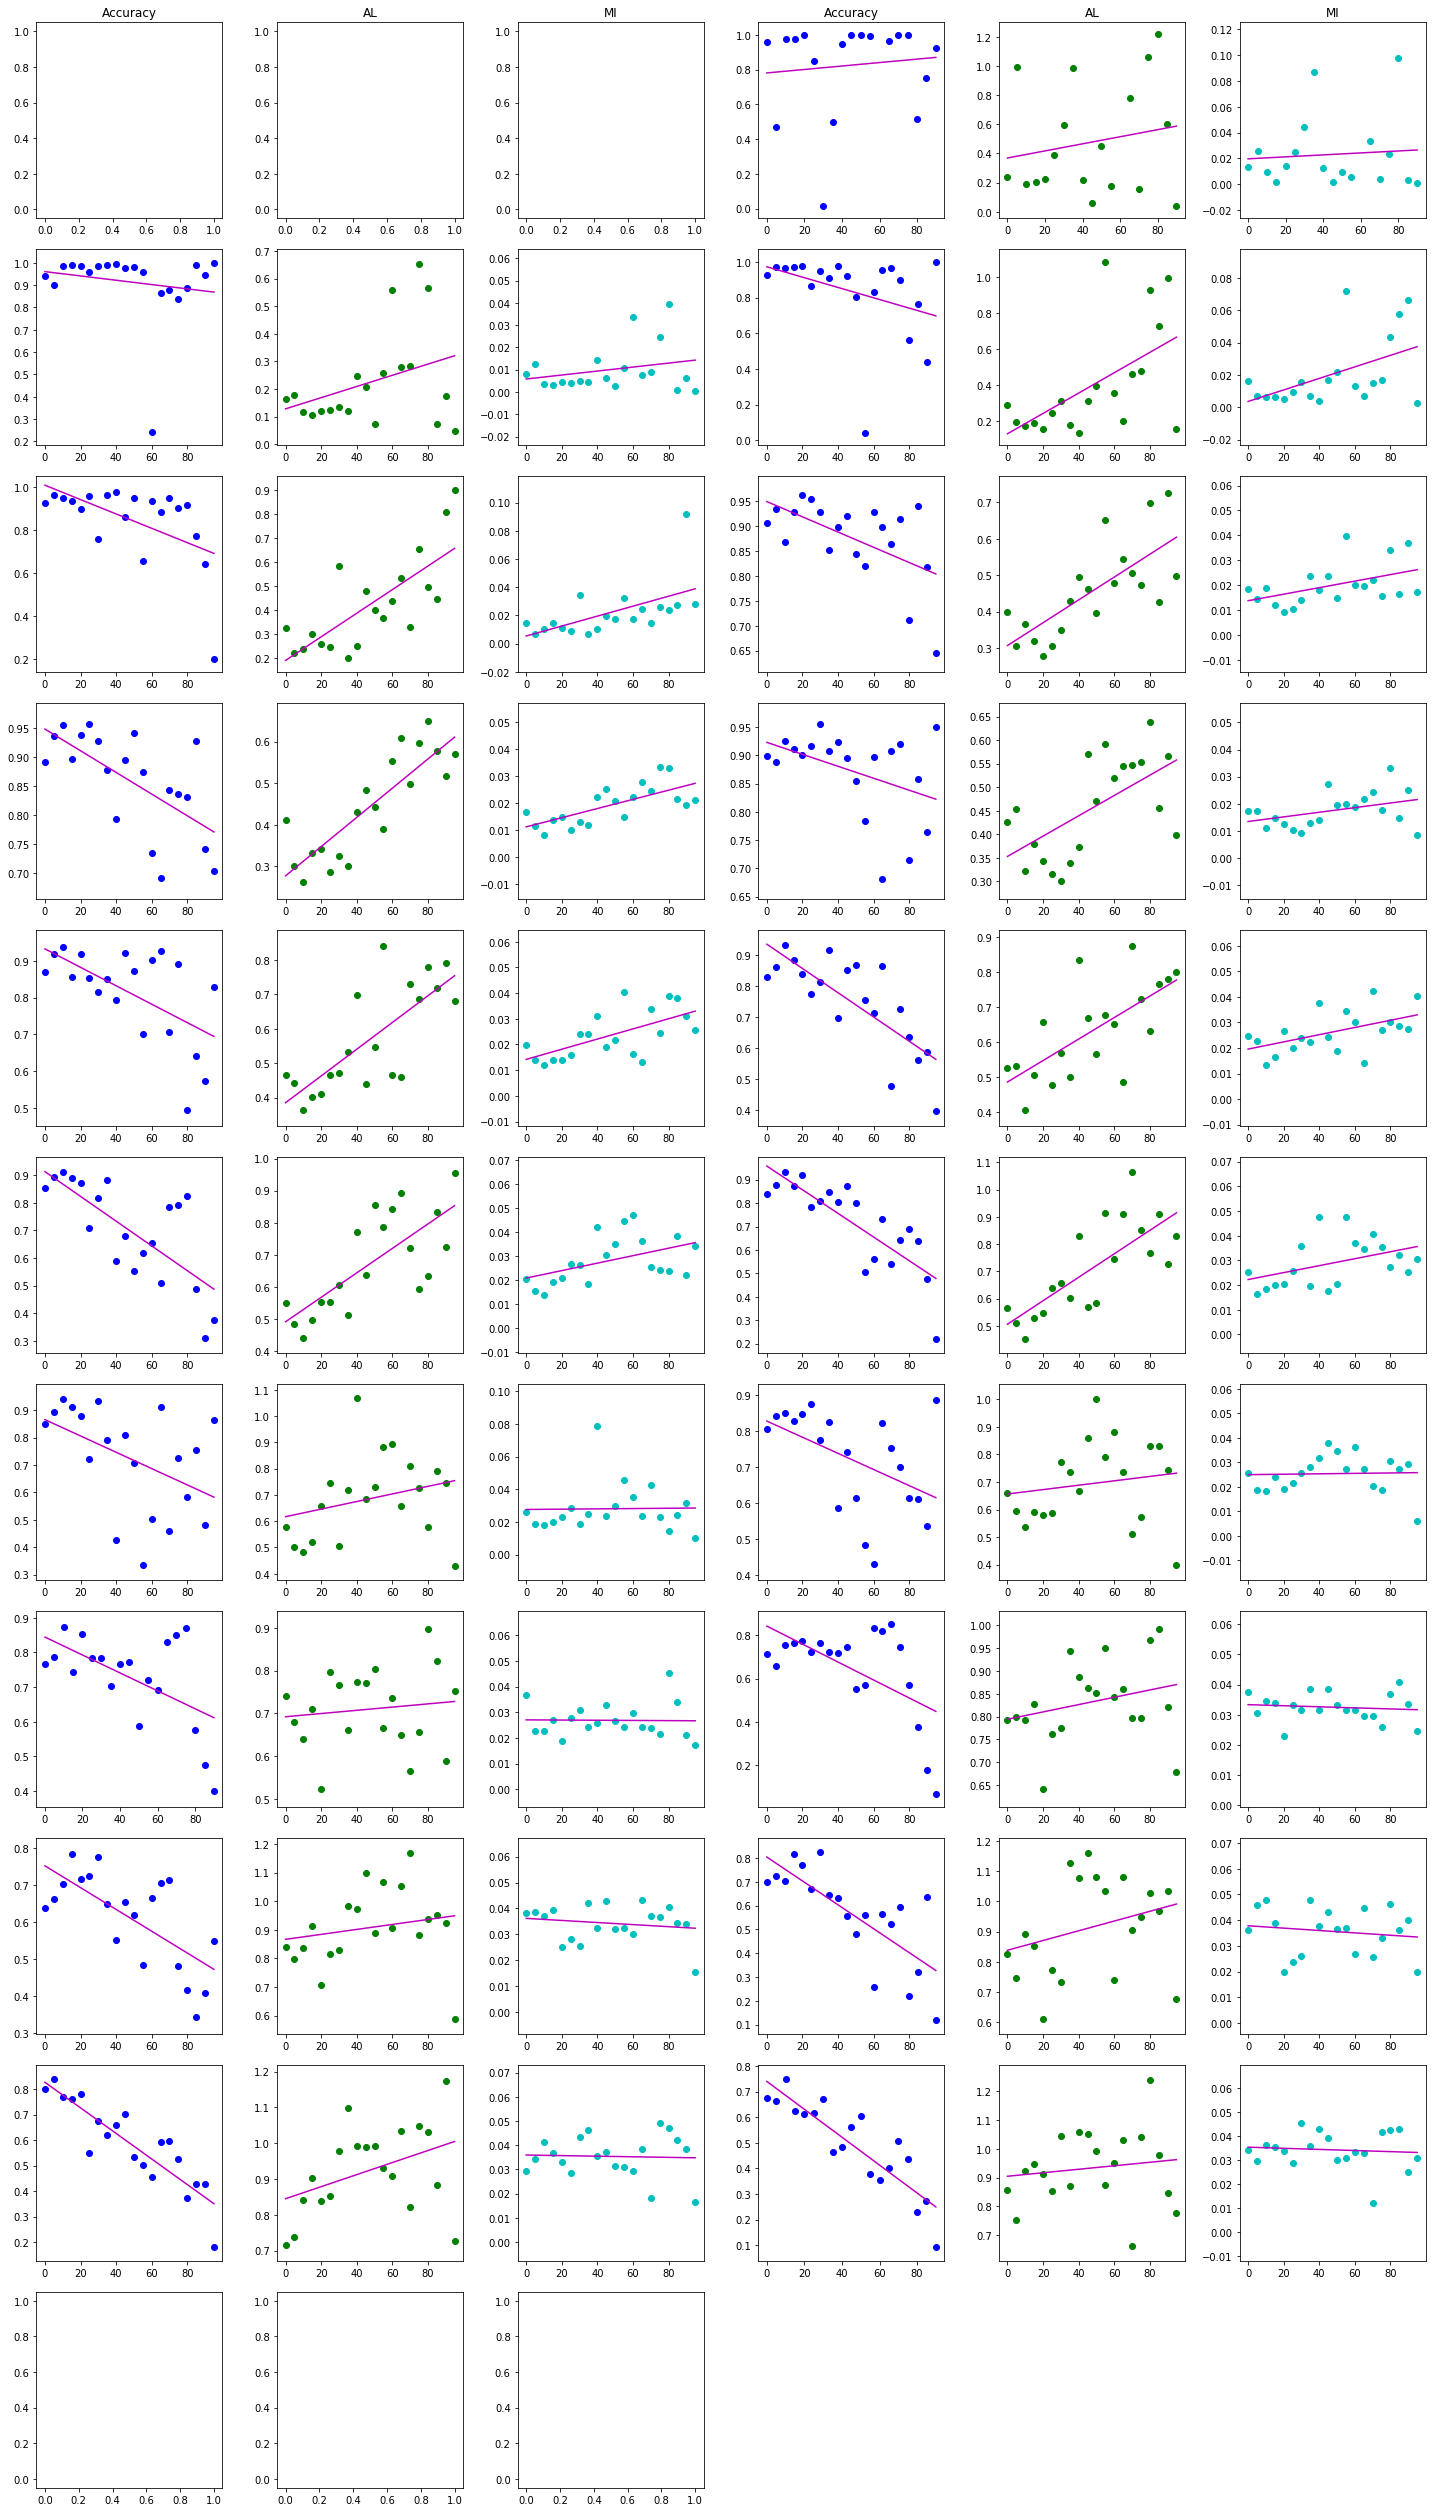

In [17]:
if visualize:
    plt.figure(figsize=( 20,20/(col*len(ylabels))*((res+1)/2) ),
               facecolor='white')

    for i in range(res+1):
        for j, ylabel in enumerate(ylabels):
            plt.subplot(int(np.ceil((res+1)/col)), col*len(ylabels), i*len(ylabels)+j+1)
            if i < 2:
                plt.title(ylabel)
            corr_axis = zzz[i,:,j]
            corr_mask = corr_axis != 0
            corr_plot_x = occlusion_axis[corr_mask]
            corr_plot_y = corr_axis[corr_mask]
            plt.scatter(corr_plot_x, corr_plot_y, color=colors[j])

            if corr_plot_x.size > 1:
                f = np.poly1d(np.polyfit(corr_plot_x, corr_plot_y, 1))
                plt.plot(corr_plot_x, f(corr_plot_x), color='m')

            _, pvalues[j,i] = stats.ttest_ind(corr_plot_x, corr_plot_y)

    pvalues_accuracy = pvalues[0][~np.isnan(pvalues[0])]
    pvalues_al = pvalues[1][~np.isnan(pvalues[1])]
    pvalues_mi = pvalues[2][~np.isnan(pvalues[2])]
    print('Occlusion-accuracy p-value: ' + str(pvalues_accuracy.mean()) + '    ' + 
           str(pvalues_accuracy[pvalues_accuracy < .05].size) + '/' + str(pvalues_accuracy.size) + ' significant')
    print('Occlusion-AL p-value: ' + str(pvalues_al.mean()) + '    ' + 
           str(pvalues_al[pvalues_al < .05].size) + '/' + str(pvalues_al.size) + ' significant')
    print('Occlusion-MI p-value: ' + str(pvalues_mi.mean()) + '    ' + 
           str(pvalues_mi[pvalues_mi < .05].size) + '/' + str(pvalues_mi.size) + ' significant')


    plt.tight_layout()
    plt.show()

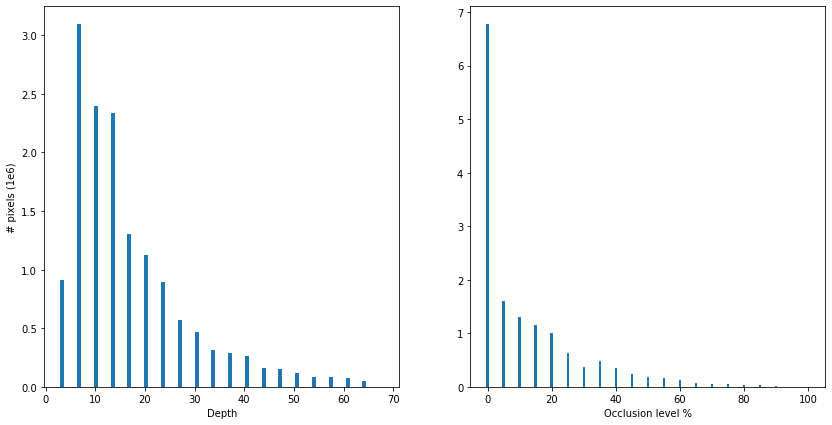

In [16]:

plt.figure(figsize=(14,7), facecolor='white')

depth_y = []
for d in depth_axis[1:]:
    data_in = data[(data[:,2] >= d) &
                   (data[:,2] < d+depth_step)]
    depth_y.append(len(data_in)/1000000)
plt.subplot(121)
plt.xlabel('Depth')
plt.ylabel('# pixels (1e6)')
plt.bar(depth_axis[1:], depth_y)


occlusion_y = []
for o in occlusion_axis:
    data_in = data[(data[:,3] >= o) &
                   (data[:,3] < o+occlusion_step)]
    occlusion_y.append(len(data_in)/1000000)
plt.subplot(122)
plt.xlabel('Occlusion level %')
plt.bar(occlusion_axis, occlusion_y)

plt.show()